<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=611f3d1622e1079b366a3e821db776efc9d233e3a418ec13ec43258a68e02f84
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

# 前処理

In [8]:
import matplotlib.pyplot as plt
import japanize_matplotlib

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [9]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [10]:
# 全列欠損を削除

df.dropna(how="all", inplace=True)

In [11]:
# 備考欄

df["備考欄"] = df["備考欄"].str.replace("\n", "")
df["備考欄"] = df["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df["備考欄"] = df["備考欄"].str.replace("・", "、")
df["備考欄"] = df["備考欄"].fillna("")

In [12]:
# 発表日

flg_is_serial = df["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df.loc[~flg_is_serial, "発表日"])

df["発表日"] = pd.concat([fromString, fromSerial])

In [13]:
# ステータス

df["ステータス"] = df["発症日"].mask(df["発症日"].astype("str").str.isdigit(), "症状あり")

In [14]:
# 発症日

df["発症日"] = df["発症日"].where(df["発症日"].astype("str").str.isdigit())
df["発症日"] = pd.to_datetime(df["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

# 年代確認

## 年代別グラフ

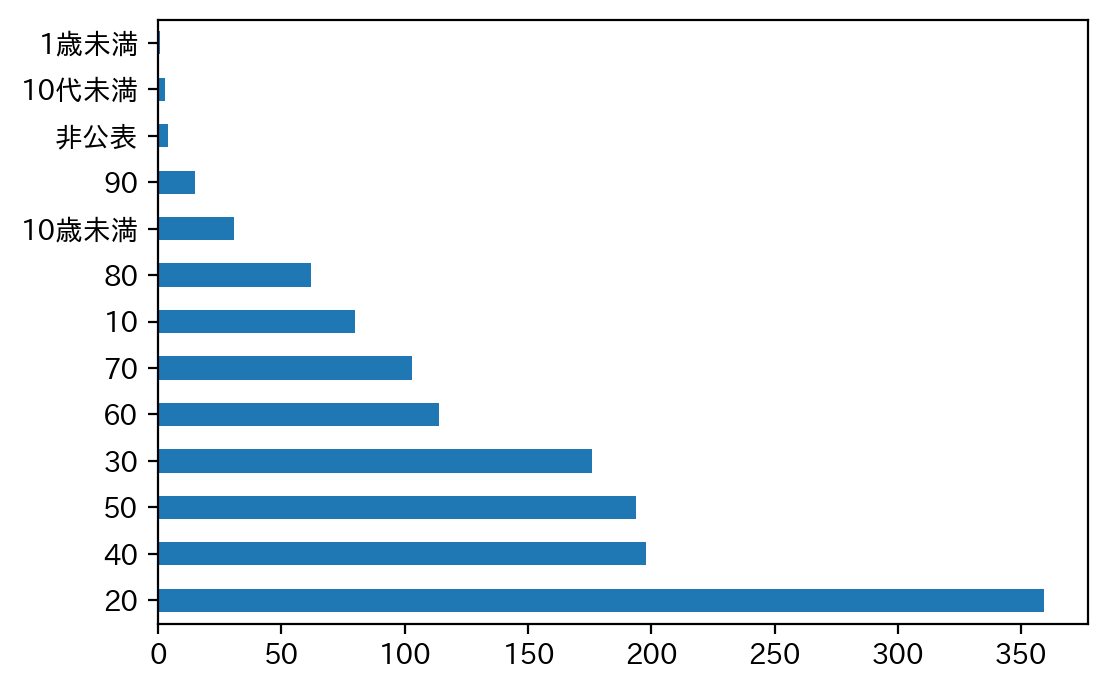

In [15]:
df["年代"].value_counts().plot.barh()

## 年代別一覧

In [16]:
df["年代"].value_counts()

20       359
40       198
50       194
30       176
60       114
70       103
10        80
80        62
10歳未満     31
90        15
非公表        4
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

# 性別確認

## 性別別グラフ

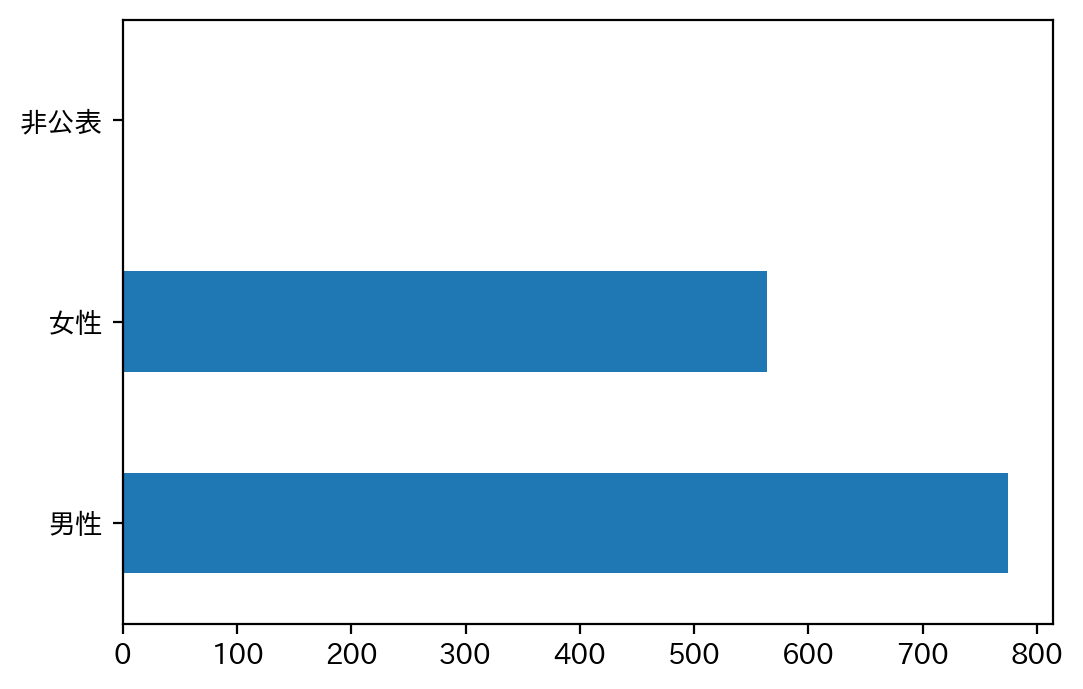

In [17]:
df["性別"].value_counts().plot.barh()

## 性別別一覧

In [18]:
df["性別"].value_counts()

男性     775
女性     564
非公表      1
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

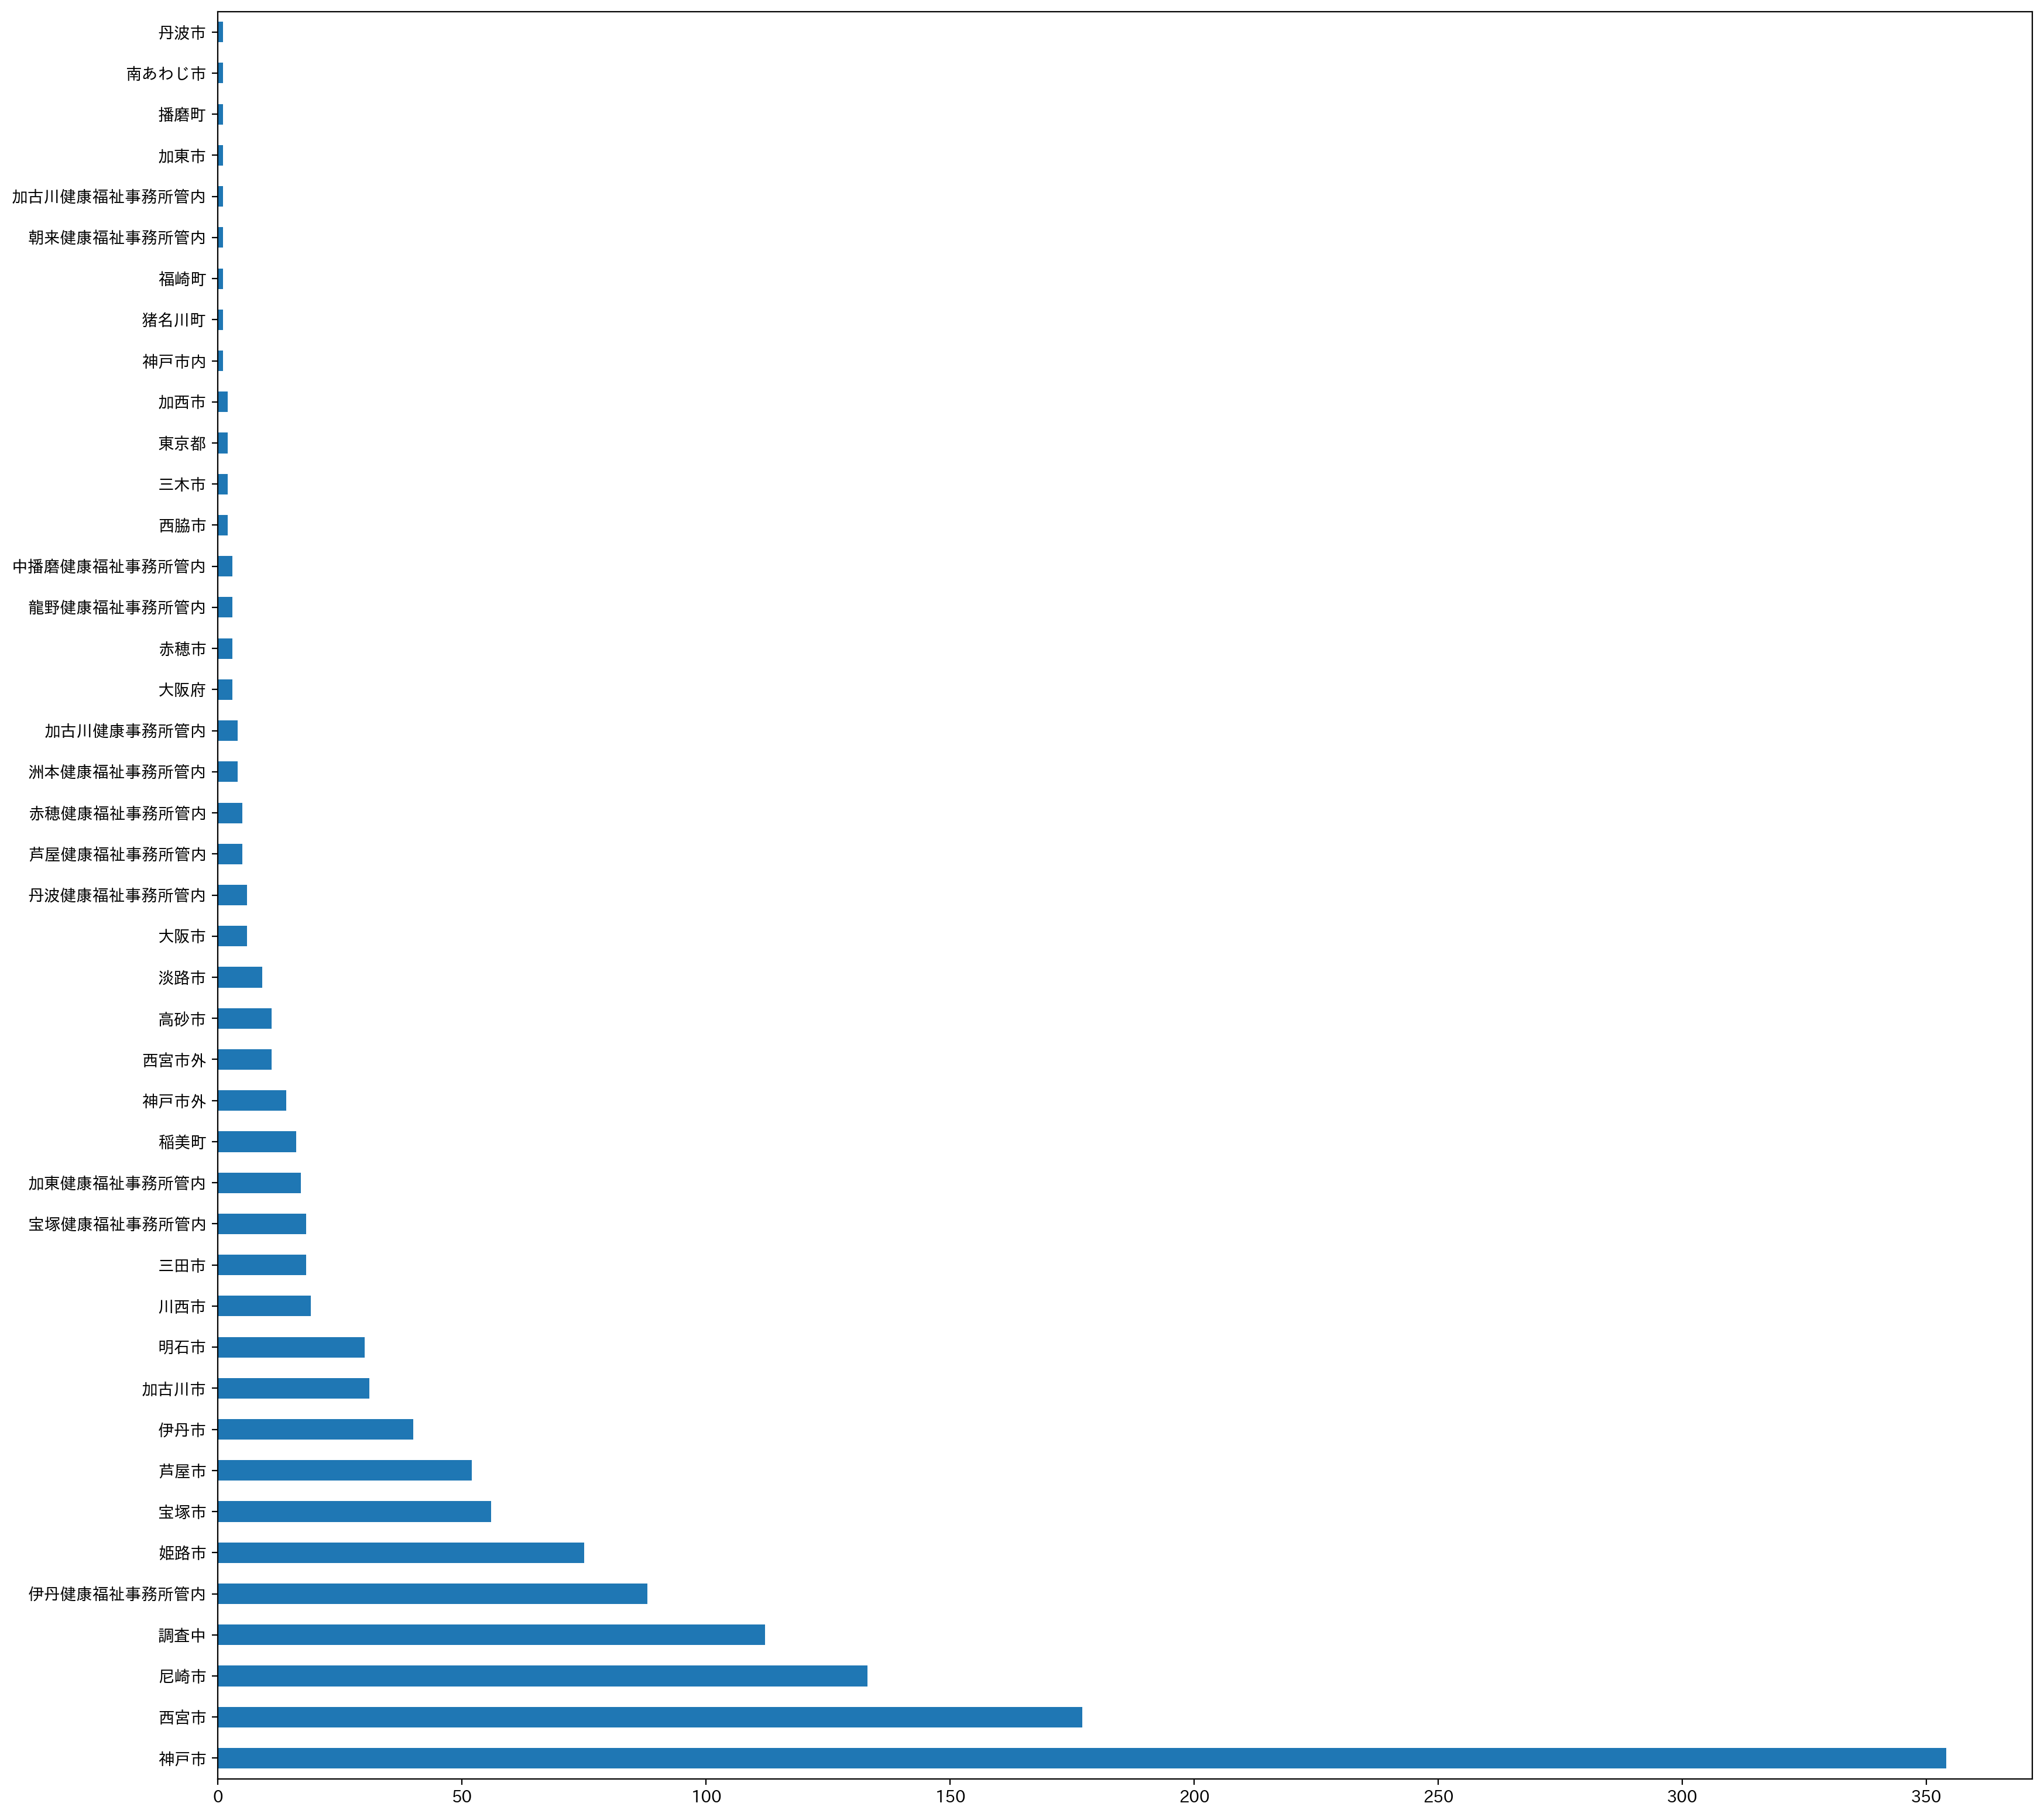

In [19]:
df["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [20]:
df["居住地"].value_counts()

神戸市             354
西宮市             177
尼崎市             133
調査中             112
伊丹健康福祉事務所管内      88
姫路市              75
宝塚市              56
芦屋市              52
伊丹市              40
加古川市             31
明石市              30
川西市              19
三田市              18
宝塚健康福祉事務所管内      18
加東健康福祉事務所管内      17
稲美町              16
神戸市外             14
西宮市外             11
高砂市              11
淡路市               9
大阪市               6
丹波健康福祉事務所管内       6
芦屋健康福祉事務所管内       5
赤穂健康福祉事務所管内       5
洲本健康福祉事務所管内       4
加古川健康事務所管内        4
大阪府               3
赤穂市               3
龍野健康福祉事務所管内       3
中播磨健康福祉事務所管内      3
西脇市               2
三木市               2
東京都               2
加西市               2
神戸市内              1
猪名川町              1
福崎町               1
朝来健康福祉事務所管内       1
加古川健康福祉事務所管内      1
加東市               1
播磨町               1
南あわじ市             1
丹波市               1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

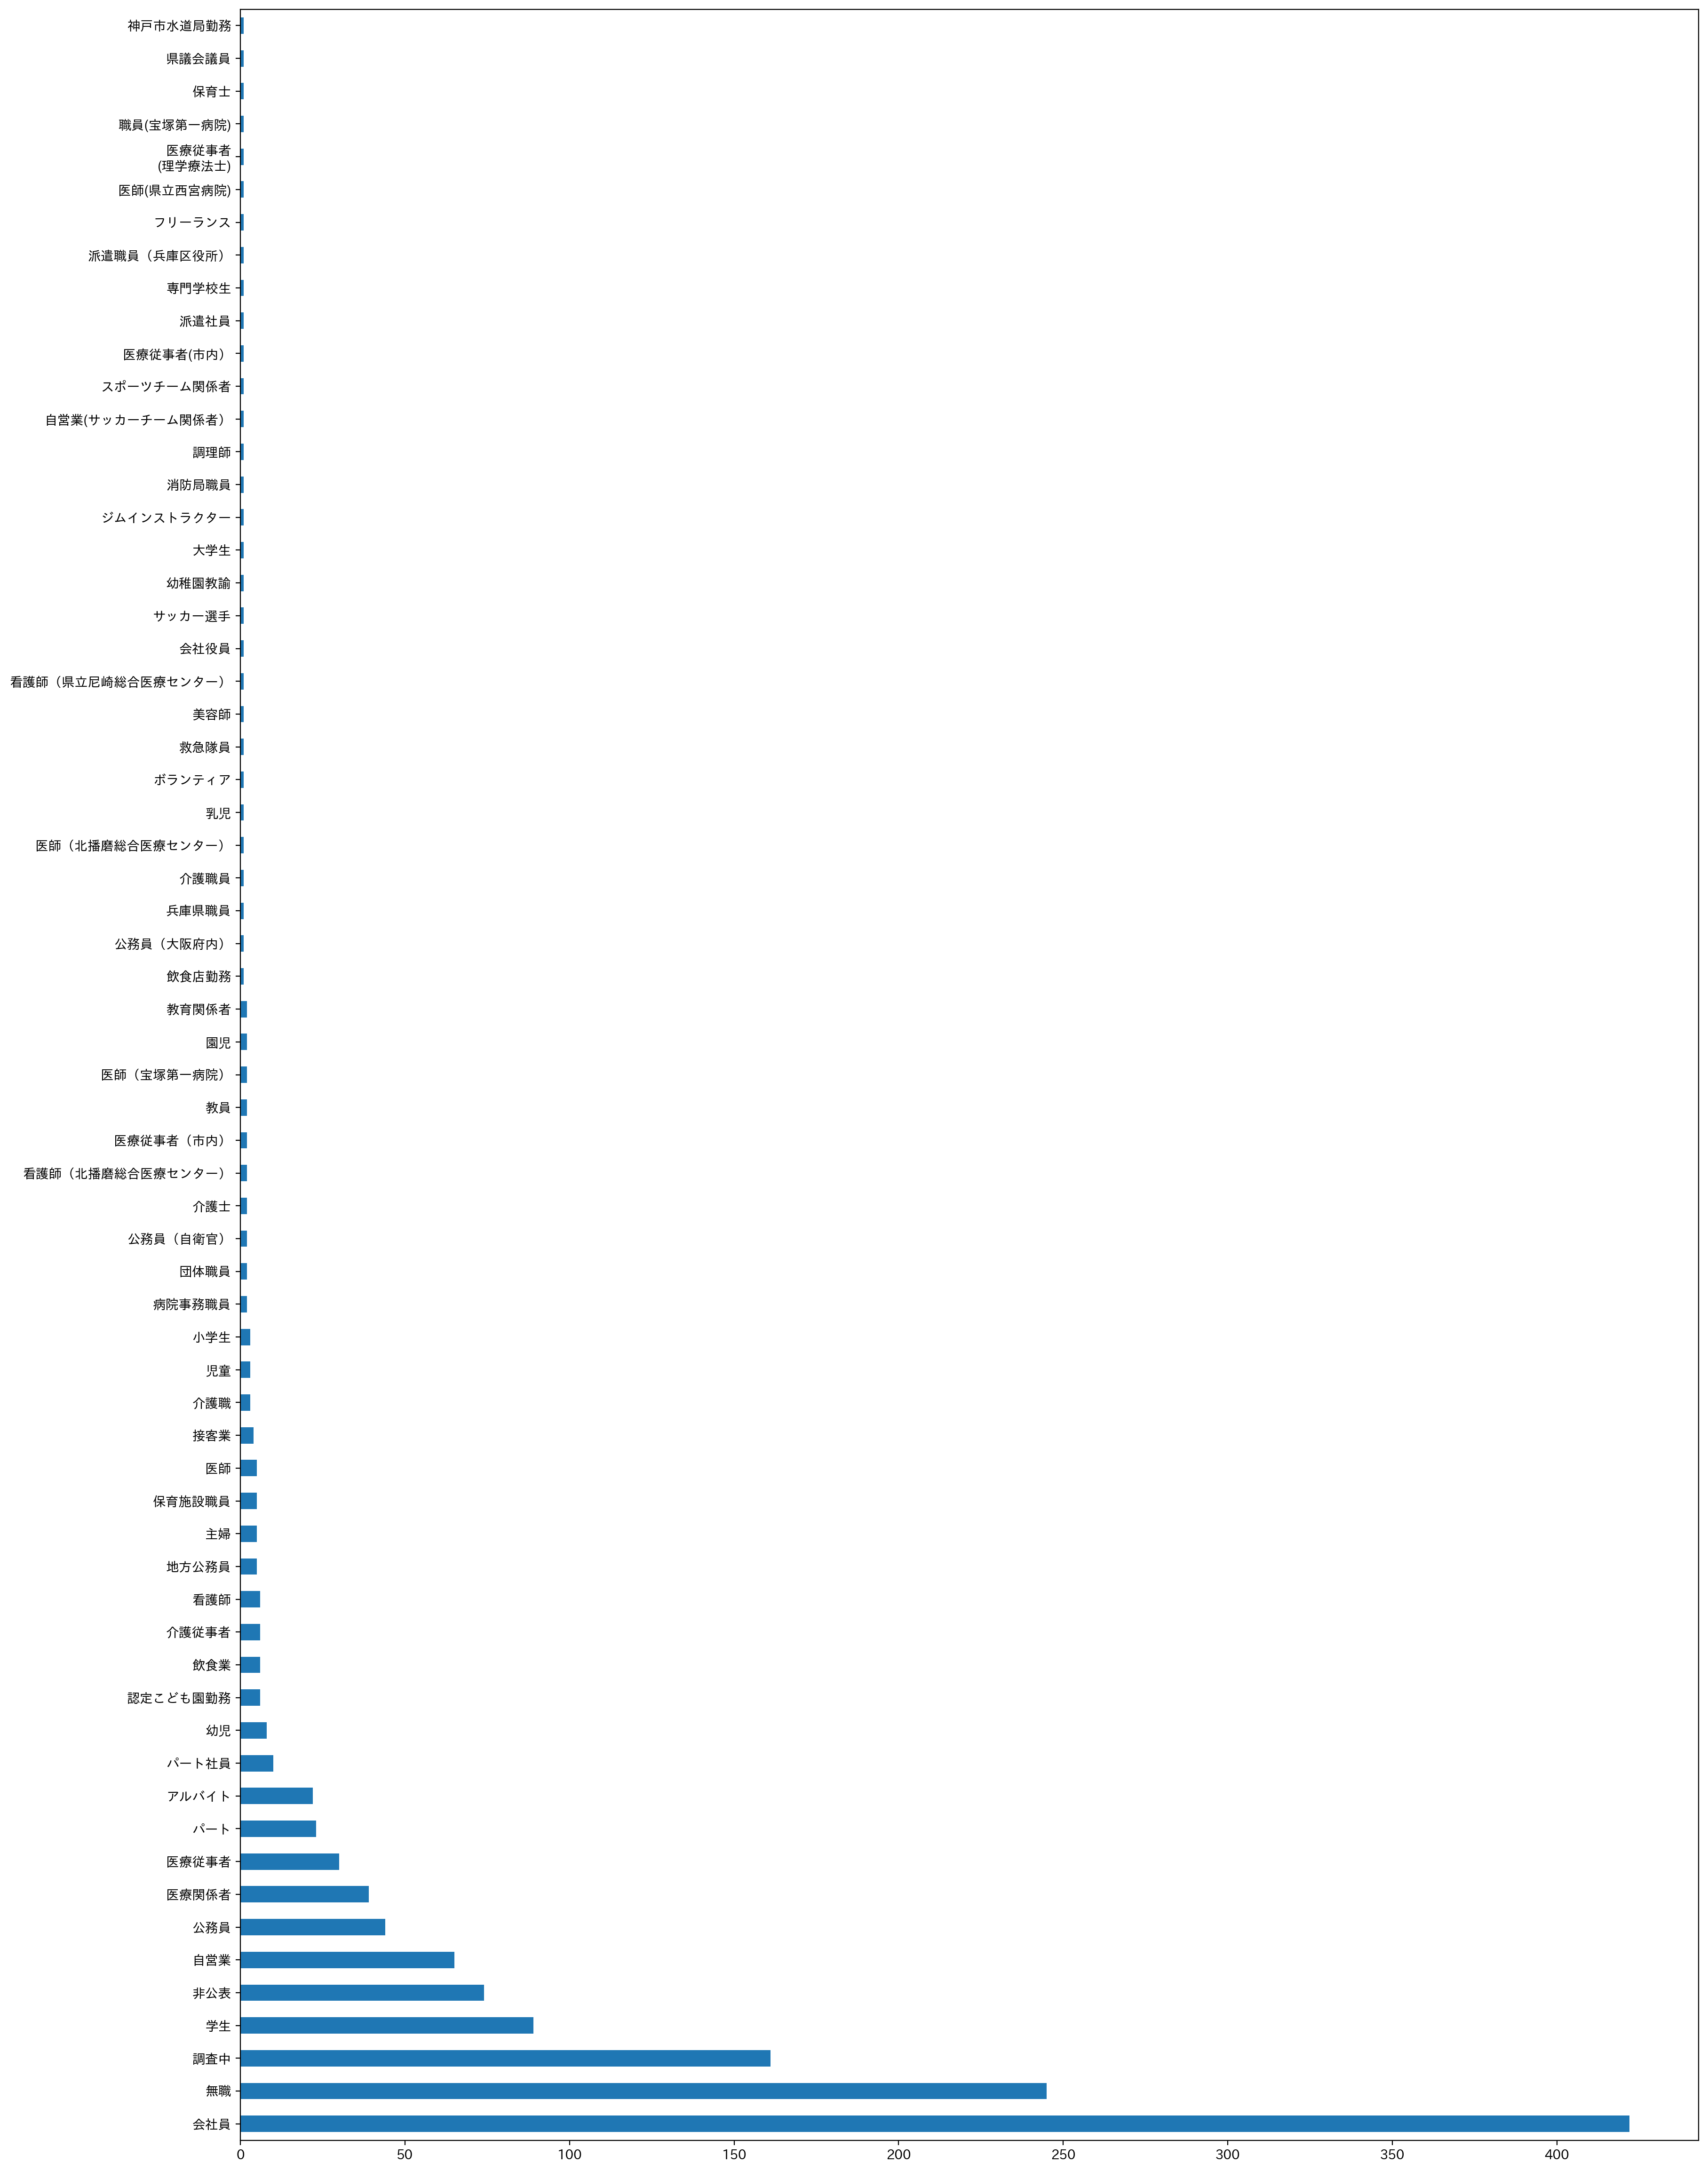

In [21]:
df["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [22]:
df["職業"].value_counts()

会社員               422
無職                245
調査中               161
学生                 89
非公表                74
                 ... 
医療従事者\n(理学療法士)      1
職員(宝塚第一病院)          1
保育士                 1
県議会議員               1
神戸市水道局勤務            1
Name: 職業, Length: 65, dtype: int64

# 管轄確認

## 管轄別グラフ

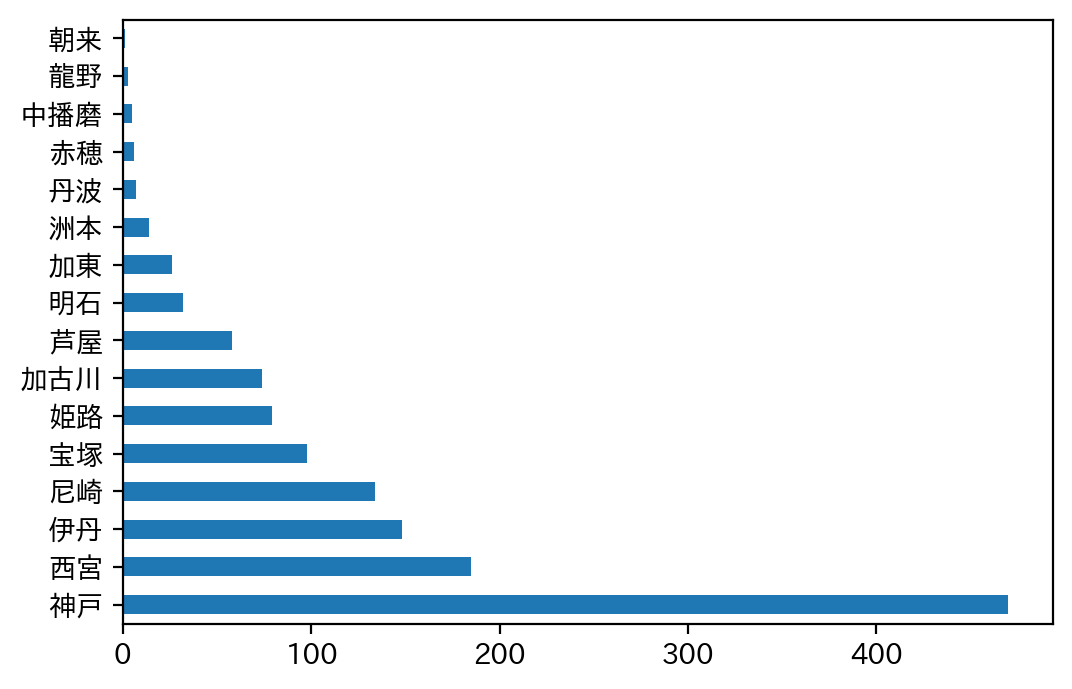

In [23]:
df["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [24]:
df["管轄"].value_counts()

神戸     470
西宮     185
伊丹     148
尼崎     134
宝塚      98
姫路      79
加古川     74
芦屋      58
明石      32
加東      26
洲本      14
丹波       7
赤穂       6
中播磨      5
龍野       3
朝来       1
Name: 管轄, dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

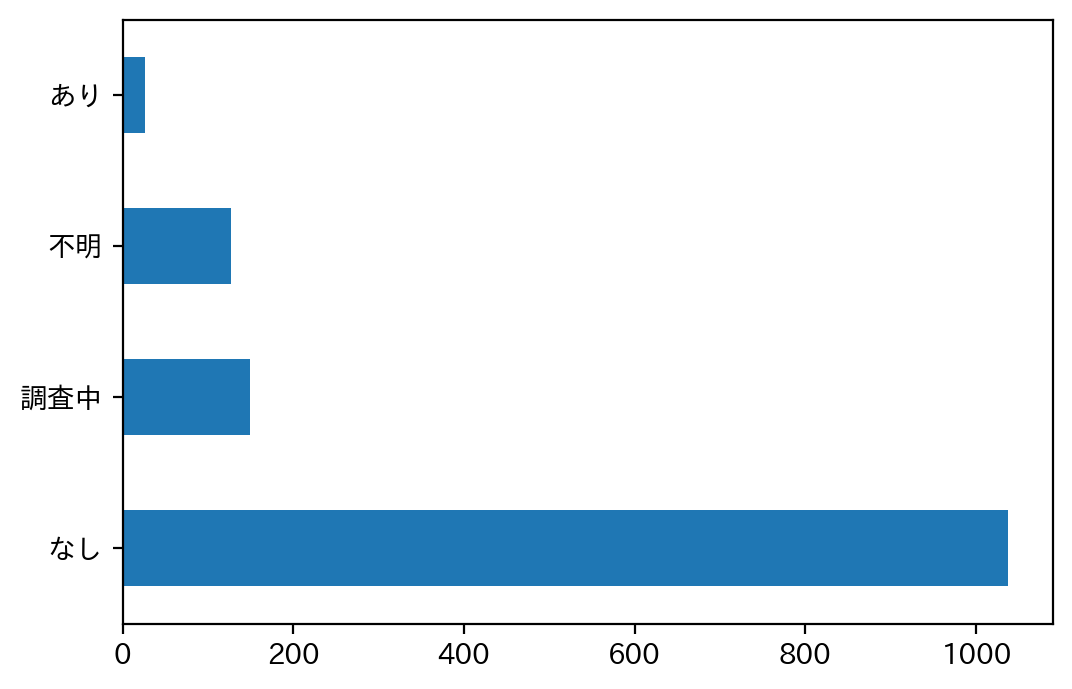

In [25]:
df["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [26]:
df["渡航歴"].value_counts()

なし     1038
調査中     149
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

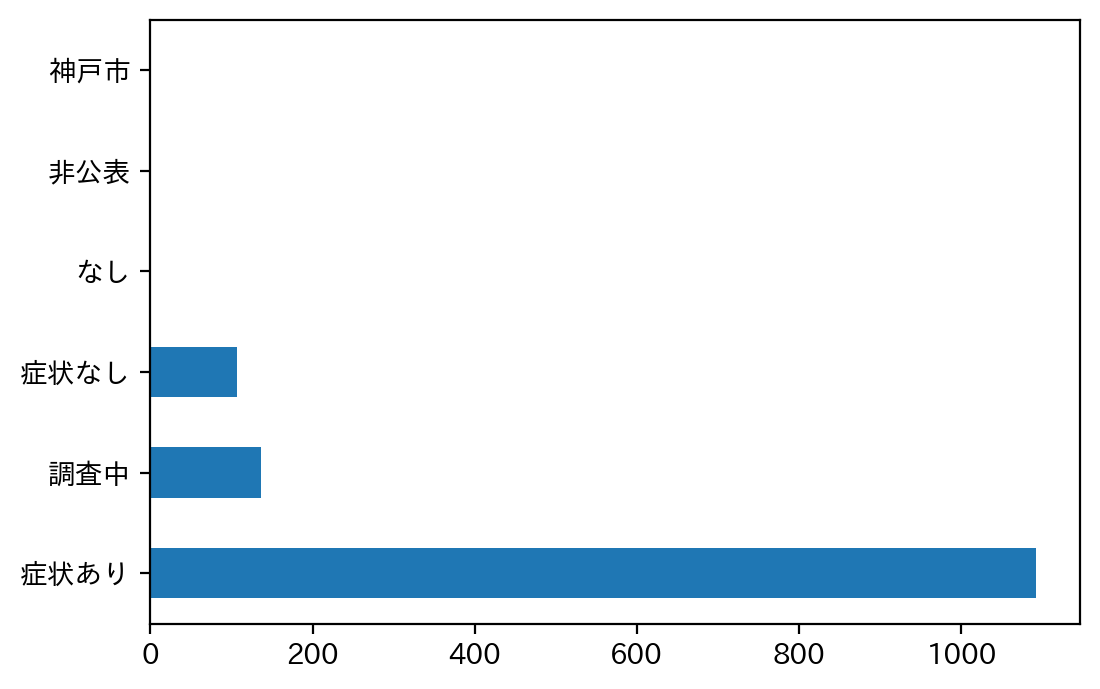

In [27]:
df["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [28]:
df["ステータス"].value_counts()

症状あり    1093
調査中      137
症状なし     107
なし         1
非公表        1
神戸市        1
Name: ステータス, dtype: int64

# 外れ値確認

## 居住地

In [29]:
nlist = df.loc[~df["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "事務所管内")) & ~(df["居住地"] == "調査中"), "居住地"].unique()
df[df["居住地"].isin(nlist)]

,番号,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス


## ステータス

In [30]:
df[~df["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,番号,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
411,931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし
591,751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市


## 渡航歴

In [31]:
df[~df["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,番号,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス


# 全体確認

In [32]:
df

,番号,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
2,1340,2020-08-03,20,男性,加古川,稲美町,会社員,2020-08-01,なし,陽性患者の濃厚接触者,症状あり
3,1339,2020-08-03,60,女性,西宮,西宮市,パート,NaT,なし,県No1244の濃厚接触者,症状なし
4,1338,2020-08-03,40,男性,西宮,西宮市,会社員,2020-07-31,なし,大阪市で発生した患者の濃厚接触者,症状あり
5,1337,2020-08-03,30,女性,西宮,西宮市,会社員,2020-07-31,なし,行動歴調査中,症状あり
6,1336,2020-08-03,70,男性,西宮,西宮市,無職,2020-07-23,なし,行動歴調査中,症状あり
...,...,...,...,...,...,...,...,...,...,...,...
1337,5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり
1338,4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり
1339,3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり
1340,2,2020-03-03,40,男性,神戸,神戸市,会社員,2020-02-27,なし,感染経路確認済,症状あり


# ファイル保存

In [34]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [35]:
df.to_excel(f"陽性者一覧_{dt_now}.xlsx", index=False)

## 年齢別抽出

In [36]:
# 年齢別抽出

grouped_df = df.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# ダウンロード

In [37]:
from google.colab import files

In [38]:
files.download(f"陽性者一覧_{dt_now}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download(f"陽性者一覧（年齢別）_{dt_now}.xlsx")